# Code Description
This code takes the large output of a parameter estimation project and then post-processes all of the data

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22

All parameter sets will be loaded in through the summary file associated with the result files

This code was initially written by Ryan Neff and then continued by Griffin Hampton (GSH) - Mirage Modi played a very important role in the multiprocessing of the data

# Import Packages

In [17]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
import colorsys
from tqdm import trange
from datetime import date
import pickle
import pandas as pd

# Options

In [18]:
#Noise Increased Data
data_date_oi = "23May23"
series_tag = "SNR_100_testCase_small2_" + data_date_oi

#Standard Reference Data
gs_date_oi = "23May23"
gs_series_tag = "NoNoise_testCase_small_" + gs_date_oi

post_normalize_data = True

#This takes effect if and only if there are lots and lots of scans and we want to see fewer
n_iter_subset = 20


# Signal Functions

In [19]:
def G_biX_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return signal

def G_moX_off(t, con, tau, offSet): 
    signal = con*np.exp(-t/tau) + offSet
    return signal

def G_MB(t, alpha, beta, tau_1, tau_2, offSet):
    function = alpha*(beta*np.exp(-t/tau_1) + (1-beta)*np.exp(-t/tau_2)) + offSet
    return function

# Define Parameters

In [20]:
### Loading All Data Hyperparameters

with open('ExperimentalSets/' + series_tag + '/' + 'hprParameter_info_' + data_date_oi + '.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    SNR_goal = dict['SNR_goal']
    n_iterations = dict['n_noise_realizations']
    num_multistarts = dict['num_multistarts']
    lambdas = dict['lambdas']
    tdata = dict['tdata']
    data_file_oi = dict["data_file"]
    data_slice_oi = dict["data_slice"]
    model_oi = dict['model_oi']
    ob_weight = dict['ob_weight']
    upper_bound = dict['upper_bound']
    mask_amp = dict['mask_amp']
    masked_region = dict['masked_region']
    n_hori = dict['n_horizontal']
    n_vert = dict['n_verticle']
    add_noise, add_mask, apply_normalization, subsection, MB_model, model_selection, multistart_method, testCase = dict['options']
    SNR_array = dict['SNR_array']
    handle.close()

n_elements = len(tdata)

n_lambdas = len(lambdas)

###################### Parameters Loop Through

param_name_list = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']

if MB_model:
    post_normalize_data = False

if subsection:
    vert1 = 37
    vert2 = 47
    hori1 = 25
    hori2 = 70
elif testCase:
    vert1 = 0
    vert2 = 9
    hori1 = 0
    hori2 = 9
else:
    vert1 = 90             #60     #108
    vert2 = 110            #125     #116
    hori1 = 70            #100      #86
    hori2 = 130            #115      #93

vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)
noiseRegion = [vert1,vert2,hori1,hori2]

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

In [21]:
with open('ExperimentalSets/' + gs_series_tag + '/' + 'hprParameter_info_' + gs_date_oi + '.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    gs_SNR_goal = dict['SNR_goal']
    gs_n_iterations = dict['n_noise_realizations']
    gs_num_multistarts = dict['num_multistarts']
    gs_lambdas = dict['lambdas']
    gs_tdata = dict['tdata']
    gs_data_file_oi = dict["data_file"]
    gs_data_slice_oi = dict["data_slice"]
    gs_model_oi = dict['model_oi']
    gs_ob_weight = dict['ob_weight']
    gs_upper_bound = dict['upper_bound']
    gs_mask_amp = dict['mask_amp']
    gs_masked_region = dict['masked_region']
    gs_n_hori = dict['n_horizontal']
    gs_n_vert = dict['n_verticle']
    gs_add_noise, gs_add_mask, gs_apply_normalization, gs_subsection, gs_MB_model, gs_model_selection, gs_multistart_method, gs_testCase = dict['options']
    gs_SNR_array = dict['SNR_array']
    handle.close()


In [22]:
assert(add_noise == True)
assert(gs_add_noise == False)

assert(gs_mask_amp == mask_amp)
assert(gs_n_hori == n_hori)
assert(gs_n_vert == n_vert)
assert(gs_apply_normalization == apply_normalization)
assert(gs_model_oi == model_oi)

print("No alignment errors")


No alignment errors


In [23]:
print(gs_SNR_array)

[259.6127198034928]


# Define General Functions

### Small Helper Functions

In [24]:
########################### Simple Functions ##############################

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1, initial_shape[-1]))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    coeficients = np.where(coeficients == 0, 1-coeficients, coeficients) #to avoid dividing by zero
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

def to_readable(file):
    df = pd.read_pickle(file)
    ALL_TYPES = np.stack(df["Type"].values) #shape: (voxel)
    ALL_DATA = np.stack(df["Data"].values) #shape: (voxel)
    ALL_INDICES = np.stack(df["Indices"].values) #shape: (voxel)

    ALL_ESTIMATES = df["Params"].values #shape: (voxel, lambda, popt)
    ALL_RSS = df["RSS"].values #shape: (voxel, lambda)
    
    return ALL_DATA, ALL_INDICES, ALL_TYPES, ALL_ESTIMATES, ALL_RSS


### Processing Results Functions

In [25]:
##### Regularization Functions on Stored Data

def get_GCV_value(params, RSS, lamb):

    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    GCVjacobian = J(tdata, *params[:4])
    if (lamb < 1e-9):
        GCVdenominator = (len(tdata) - np.linalg.matrix_rank(GCVjacobian))**2
    else:
        C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(lamb**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
        (n,n) = C_GCV.shape
        identity = np.identity(n)
        GCVdenominator = (identity - C_GCV).trace()
    GCV = RSS/(GCVdenominator**2)
    return GCV

def pull_GCV(est_combos, RSS_combos, lambda_array):

    GCV_hold_values = []

    count_singular = 0

    for iLam in range(len(lambda_array)):    #Loop through all lambda values
        try:
            GCV_value = get_GCV_value(est_combos[iLam], RSS_combos[iLam], lambda_array[iLam])
            GCV_hold_values.append(GCV_value)
        except:
            GCV_hold_values.append(np.inf)
            count_singular += 1

    min_GCV_index = np.argmin(GCV_hold_values)   
    GCV_final_params = est_combos[min_GCV_index, :]
    GCV_RSS = RSS_combos[min_GCV_index]
    GCV_final_lam = lambda_array[min_GCV_index]
    GCV_curves = GCV_hold_values
    
    if count_singular > 0:
        print(f"Pixel had {count_singular} singular GCV values associated with nonzero lambda values")
    
    return GCV_final_lam, GCV_final_params, GCV_RSS, GCV_curves



### Loading and Processing Data Function

In [26]:
def prepare_data(n_iterations, series_tag, n_v = n_vert, n_h = n_hori, n_lam = n_lambdas):

    nonreg_estimates = np.zeros((n_iterations, n_v, n_h, 5))
    GCV_estimates = np.zeros((n_iterations, n_v, n_h, 5))
    nonreg_RSS = np.ones((n_iterations, n_v, n_h))*np.inf
    GCV_RSS_list = np.ones((n_iterations, n_v, n_h))*np.inf
    GCV_lambdas = np.zeros((n_iterations, n_v, n_h))
    GCV_curves = np.zeros((n_iterations, n_v, n_h, n_lambdas))
    all_data = np.zeros((n_iterations, n_v, n_h, n_elements))
    all_BIC_choices = np.zeros((n_iterations, n_h, n_v))

    for iter in trange(n_iterations):
        data_name = "ExperimentalSets/" + series_tag + "/brainData_" + series_tag + f"_iteration_{iter}.pkl"

        print("Retrieving data for " + data_name)
        data, indices, types, estimates, RSS = to_readable(data_name)

        for index in range(indices.shape[0]):

            # print(f"Working on horizontal {indices_rs[iter][0]} and verticle {indices_rs[iter][1]}")
            all_BIC_choices[iter, indices[index][0], indices[index][1]] = (types[index]=='biX')
            all_data[iter, indices[index][0], indices[index][1],:] = data[index,:]

            if types[index]=='biX':
                GCV_lambda, GCV_params, GCV_RSS, GCV_curve = pull_GCV(estimates[index], RSS[index], lambdas)

                GCV_estimates[iter, indices[index][0], indices[index][1], :] = GCV_params
                GCV_RSS_list[iter, indices[index][0], indices[index][1]] = GCV_RSS
                GCV_lambdas[iter, indices[index][0], indices[index][1]] = GCV_lambda
                GCV_curves[iter, indices[index][0], indices[index][1], :] = GCV_curve

                nonreg_estimates[iter, indices[index][0], indices[index][1], :] = estimates[index][0,:]
                nonreg_RSS[iter, indices[index][0], indices[index][1]] = RSS[index][0]
            elif types[index] == 'moX':
                GCV_estimates[iter, indices[index][0], indices[index][1], 1:] = [estimates[index][0],0, *estimates[index][1:]]
                nonreg_estimates[iter, indices[index][0], indices[index][1], 1:] = [estimates[index][0],0, *estimates[index][1:]]
                GCV_RSS_list[iter, indices[index][0], indices[index][1]] = RSS[index]
                nonreg_RSS[iter, indices[index][0], indices[index][1]] = RSS[index]
            #The alternative is to be a background type which is disregarded - the parameter values are left as zeros

    all_sets = [all_BIC_choices, all_data]
    nonreg_sets = [nonreg_estimates, nonreg_RSS]
    GCV_sets = [GCV_estimates, GCV_RSS_list, GCV_lambdas, GCV_curves]

    return all_sets, nonreg_sets, GCV_sets


# Generate Data Sets

In [27]:
n_iter_input = np.min([n_iterations, n_iter_subset])
# all_nonreg_estimates, all_reg_estimates, all_RSS, all_GCV_estimates, all_GCV_lambdas, all_GCV_curves, all_data = prepare_data(n_iter_input, series_tag)
all_sets, nonreg_sets, GCV_sets = prepare_data(n_iter_input, series_tag)
[all_BIC_choices, all_data] = all_sets
[nonreg_estimates, nonreg_RSS] = nonreg_sets
[GCV_estimates, GCV_RSS, GCV_lambdas, GCV_curves] = GCV_sets

if post_normalize_data:
        nonreg_estimates = post_normalize(nonreg_estimates)
        GCV_estimates = post_normalize(GCV_estimates)

  0%|          | 0/3 [00:00<?, ?it/s]

Retrieving data for ExperimentalSets/SNR_100_testCase_small2_23May23/brainData_SNR_100_testCase_small2_23May23_iteration_0.pkl


 33%|███▎      | 1/3 [00:01<00:02,  1.05s/it]

Retrieving data for ExperimentalSets/SNR_100_testCase_small2_23May23/brainData_SNR_100_testCase_small2_23May23_iteration_1.pkl


 67%|██████▋   | 2/3 [00:01<00:00,  1.04it/s]

Retrieving data for ExperimentalSets/SNR_100_testCase_small2_23May23/brainData_SNR_100_testCase_small2_23May23_iteration_2.pkl


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


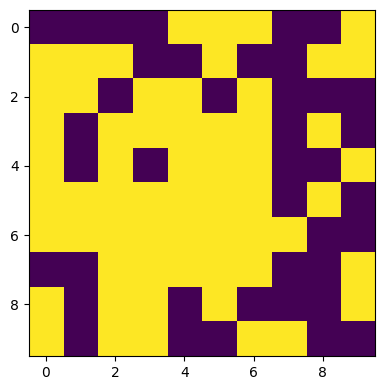

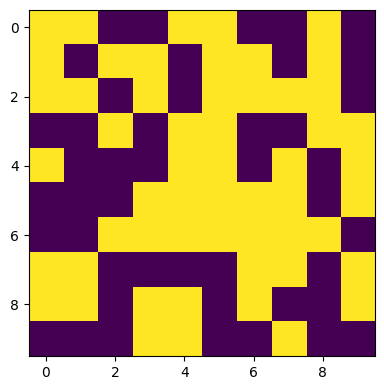

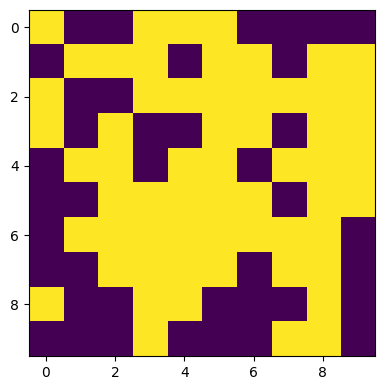

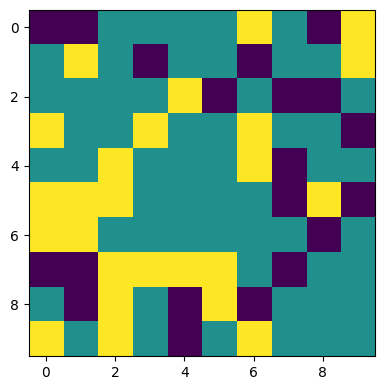

In [28]:
fig, ax = plt.subplots(1,1,figsize=(4,4),tight_layout=True)
plt.imshow(all_BIC_choices[0,:,:])

fig, ax = plt.subplots(1,1,figsize=(4,4),tight_layout=True)
plt.imshow(all_BIC_choices[1,:,:])

fig, ax = plt.subplots(1,1,figsize=(4,4),tight_layout=True)
plt.imshow(all_BIC_choices[2,:,:])

fig, ax = plt.subplots(1,1,figsize=(4,4),tight_layout=True)
plt.imshow(all_BIC_choices[0,:,:]-all_BIC_choices[1,:,:])

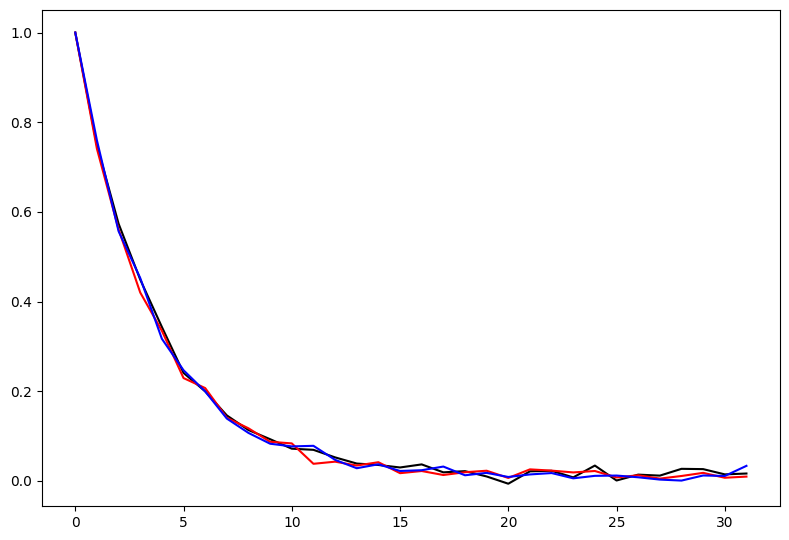

In [30]:
fig, ax = plt.subplots(1,1,figsize=(8,5.5),tight_layout=True)
plt.plot(all_data[0,0,0,:], color = 'k')
plt.plot(all_data[1,0,0,:], color = 'r')
plt.plot(all_data[2,0,0,:], color = 'b')

In [14]:
ExpResults = {
    "SNR_goal": SNR_goal,
    'n_noise_realizations': n_iter_input,
    'lambdas': lambdas,
    "data_file": data_file_oi,
    "data_slice": data_slice_oi,
    "series_tag": series_tag,
    'tdata': tdata,
    'SNR_array': SNR_array,
    'nonreg_est':all_nonreg_estimates,
    'GCV_est':all_GCV_estimates,
    'GCV_lam':all_GCV_lambdas
}

f = open('Intermediate_ExpResults/ExperimentalResults_' + day + month + year +'.pkl','wb')
pickle.dump(ExpResults,f)
f.close()

In [11]:
print(all_data[0,45,45,:])
print(all_nonreg_estimates[0,45,45,:])
print(all_nonreg_estimates[0,40,40,:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 1. 0.]
[0. 0. 1. 1. 0.]


In [13]:
# gs_nonreg_estimates, gs_reg_estimates, gs_RSS, gs_GCV_estimates, gs_GCV_lambdas, gs_GCV_curves, gs_data = prepare_data(gs_n_iterations, gs_series_tag)
gs_sets, gs_nonreg_sets, gs_GCV_sets = prepare_data(gs_n_iterations, gs_series_tag)
[gs_BIC_choices, gs_data] = gs_sets
[gs_nonreg_estimates, gs_nonreg_RSS] = gs_nonreg_sets
[gs_GCV_estimates, gs_GCV_RSS, gs_GCV_lambdas, gs_GCV_curves] = gs_GCV_sets

  0%|          | 0/1 [00:00<?, ?it/s]

Retrieving data for ExperimentalSets/NoNoise_testCase_small_23May23/brainData_NoNoise_testCase_small_23May23_iteration_0.pkl


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


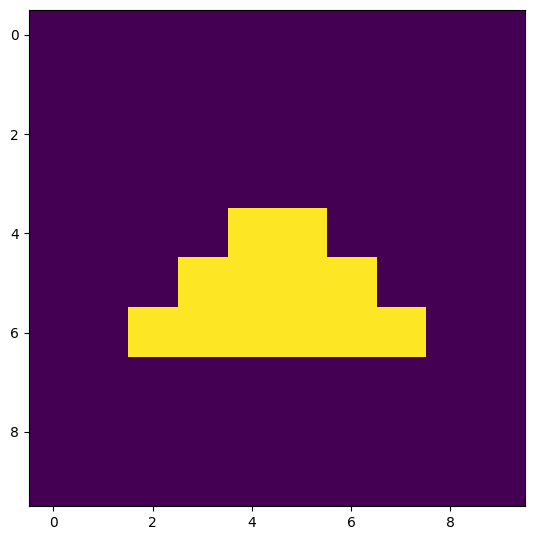

In [14]:
fig, ax = plt.subplots(1,1,figsize=(15,5.5),tight_layout=True)
plt.imshow(gs_BIC_choices[0,:,:])

In [ ]:
gs_nonreg_estimates = np.squeeze(gs_nonreg_estimates)
gs_GCV_estimates = np.squeeze(gs_GCV_estimates)
gs_GCV_lambdas = np.squeeze(gs_GCV_lambdas)
gs_data = np.squeeze(gs_data)

c1_ref = gs_nonreg_estimates[:,:,0]

In [ ]:
GS_ExpResults = {
    "SNR_goal": gs_SNR_goal,
    'n_noise_realizations': gs_n_iterations,
    'lambdas': gs_lambdas,
    "data_file": gs_data_file_oi,
    "data_slice": gs_data_slice_oi,
    "series_tag": gs_series_tag,
    'tdata': tdata,
    'SNR_array': gs_SNR_array,
    'nonreg_est':gs_nonreg_estimates,
    'GCV_est':gs_GCV_estimates,
    'GCV_lam':gs_GCV_lambdas

}

f = open('Intermediate_ExpResults/GS_ExperimentalResults_' + day + month + year +'.pkl','wb')
pickle.dump(GS_ExpResults,f)
f.close()